## Aperture photometry on PAL5 3.6μm Spitzer mosaic - functions

This notebook builds on the previous aperture photometry work with the aim to automate some of the process to avoid rewriting code and replacing many values - these can be defined at the start and the process left to run, perhaps with a check in the middle to ensure the images look okay and the rest of the analysis can proceed.

As usual, the notebook starts with a list of inputs for aperture photometry:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits # FITS file management
from astropy.stats import sigma_clipped_stats # use within star detection
from photutils import aperture_photometry # used to perform photometry using apertures
from photutils import DAOStarFinder # star finding algorithm
from photutils import CircularAperture, CircularAnnulus

The first thing to do is import the relevant image(s) and the Spitzer channel the image is from, in order to determine some parameters in the magnitude analysis. This analysis uses Spitzer channel 1 (3.6um) and channel 2 (4.5um) images, and the analysis has been assumed to use apertures and annuli of sizes 6.0, 6.0 and 14.0 respectively, using other values will result in incorrect magnitude values as the aperture corrections will be incorrect for the aperture sizes used.

In [11]:
def AperPhot(image, channel, fwhm, sigma_val, roundlo, roundhi, save_img_numb):
    # image: FITS file format image to be used in the analysis
    # channel: input 1 or 2 for which channel corresponds to the image imported (channel 1: 3.6um, channel 2: 4.5um)
    # fwhm: desired full-width-at-half-maximum value for star detection algorithm
    # sigma_val: desired sigma value for statistics applied to source detection
    # roundlo/roundhi: desired roundness values for star detection algorithm in order to fine tune the detection
    # process and ignore potential galaxies etc.
    # save_img_numb: a number to be appended to the image files saved to avert overwriting files
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from astropy.io import fits # FITS file management
    from astropy.stats import sigma_clipped_stats # use within star detection
    from photutils import aperture_photometry # used to perform photometry using apertures
    from photutils import DAOStarFinder # star finding algorithm
    from photutils import CircularAperture, CircularAnnulus
    
    
    image = image
    
    if channel == 1:
        aper_corr = 1.125
        zmag = 18.8
    elif channel == 2:
        aper_corr = 1.120
        zmag = 18.32
    else:
        return print('Input either channel 1 or channel 2 only')
    
    header_list = fits.open(image)
    header = header_list[0].header
    
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    header_list.close()
    
    image_data = fits.getdata(image, ext = 0)
    
    conv_data = image_data * exptime / fluxconv
    data = conv_data
    
    # perform sigma clipped stats
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)
    
    # source detection
    daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_val * std_val, roundlo = roundlo, roundhi = roundhi)
    sources = daofind(data - median_val) # necessary here?
    print('Number of stars detected: {}'.format(len(sources)))
    
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    plt.colorbar(fraction = 0.05)
    apertures.plot(color = 'black', lw = 1., alpha = .75)
    plt.title('Aperture photometry with params: sigma = {}, fwhm = {}, roundlo = {}, roundhi = {}'
              .format(sigma_val, fwhm, roundlo, roundhi))
    plt.grid(b = True, which = 'major', lw = .5, alpha = .4, color = 'black')
    #plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    plt.savefig(r'aperture_photometry_output_images/aperture_phot_params_img{}_channel{}.png'
                .format(save_img_numb, channel))
    
    while True:
        proc = input('Proceed with analysis? Input y or n')
        if proc == 'y':
            # perform photometry
            positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
            circular_apertures = CircularAperture(positions, r = 6.)
            annuli_apertures = CircularAnnulus(positions, r_in = 6., r_out = 14.)
            apertures = [circular_apertures, annuli_apertures]

            # initial aperture photometry table
            phot_init = aperture_photometry(data, apertures)

            # background subtraction using sigma-clipped median and annuli
            annulus_masks = annuli_apertures.to_mask(method = 'center')

            bkg_median = []
            for mask in annulus_masks:
                annulus_data = mask.multiply(data)
                annulus_data_1d = annulus_data[mask.data > 0] # extract 1D array of data values
                _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
                bkg_median.append(median_sigclip)

            bkg_median = np.array(bkg_median)
            # now append bkg_median, aperture background and aperture sum background values to photometry data
            phot_init['annulus_median'] = bkg_median
            phot_init['aper_bkg'] = bkg_median * circular_apertures.area
            phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']

            phot = phot_init                    # redefine photometry table for ease
            phot['bkgsub_flux'] = float('NaN')  # populate new column to convert into flux
            phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

            for i in range(0, len(phot)):
                phot['bkgsub_flux'][i] = phot['aper_sum_bkgsub'][i] * fluxconv / exptime
                for i in range(0, len(phot)):
                    if phot['bkgsub_flux'][i] >= 0:
                        phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['bkgsub_flux'][i] * aper_corr)

            # export into csv file
            phot['id', 'xcenter', 'ycenter', 'apparent_mag'].write(r'C:\Users\lukeb\Documents\MPhys_Project\output_files\aperphot{}_channel{}.txt'
                                                                   .format(save_img_numb, channel), format = 'csv', overwrite = True)

            for col in phot.colnames:
                phot[col].info.format = '%.8g'
            return print(phot)
        if proc == 'n':
            return print('Choose different parameters')

Number of stars detected: 827


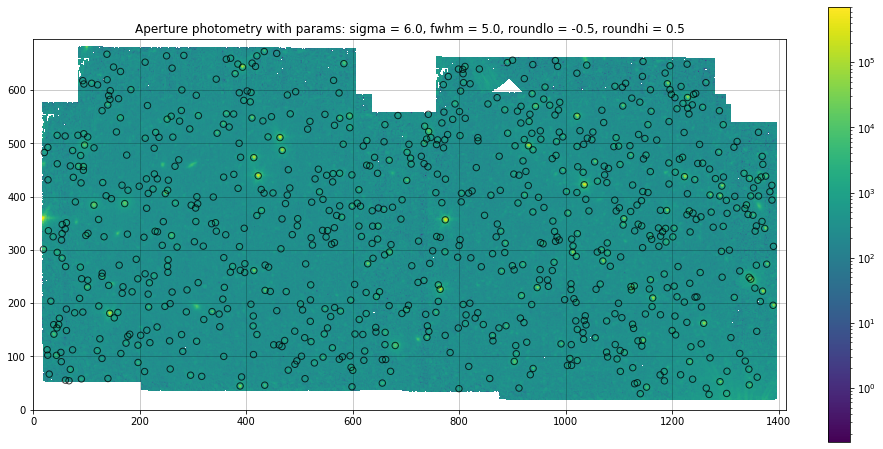

Proceed with analysis? Input y or ny


 id  xcenter   ycenter  ... aper_sum_bkgsub bkgsub_flux apparent_mag
       pix       pix    ...                                         
--- --------- --------- ... --------------- ----------- ------------
  1 1269.3064 28.508046 ...       20241.301   3.0682502    17.454892
  2 1140.1015  29.89543 ...       22256.418   3.3737089     17.35185
  3 1302.3473 30.397221 ...       56339.852      8.5402    16.343449
  4 799.47313 39.357216 ...             nan         nan          nan
  5 1264.0199 40.403954 ...       14257.475      2.1612    17.835381
  6 912.22961 40.463015 ...       16685.658   2.5292727     17.66463
  7  1151.876 42.267178 ...       170788.42   25.888731    15.139342
  8 598.51676 42.895275 ...       36765.776   5.5730903    16.806878
  9 388.36816 44.408524 ...       458425.17   69.489756    14.067317
 10 434.65172 45.887199 ...       115871.88   17.564282    15.560543
...       ...       ... ...             ...         ...          ...
818 980.56741 655.59754 ...       

<Figure size 432x288 with 0 Axes>

In [10]:
AperPhot(image = 'PAL5_data\PAL5_3p6um.fits', 
         channel = 1, 
         fwhm = 5., 
         sigma_val = 6., 
         roundlo = -.5, 
         roundhi = .5, 
         save_img_numb = 11)

In [4]:
AperPhot('PAL5_data\PAL5_3p6um.fits', 3, 5., 6., -.5, .5, 10)

Input either channel 1 or channel 2 only
